<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/side_by_side.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [2]:
!pip install pytorch-msssim -q
from pytorch_msssim import ms_ssim

# 1. Set up project in runtime
Create colab secrets for the following credentials for the repo to get runtime files and clone repo

In [3]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166766, done.
remote: Counting objects: 100% (351/351), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 166766 (delta 182), reused 288 (delta 152), pack-reused 166415
Receiving objects: 100% (166766/166766), 843.34 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (37141/37141), done.
Updating files: 100% (249515/249515), done.


'/content'

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [19]:
start = 0.80

''' Returns an array containing first [proportion] of images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return array of images
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)
  cutoff = int(len(files)*start)

  arr = []
  for i in tqdm(files[cutoff:]):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)

'''
Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
Inversion is np.moveaxis(arr, [1,2], [3,1])
'''
def make_tensor(path):
  arr = make_image_arr(path)
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))


#Extract single channel, since all 3 are the same in gray images
def make_gray_tensor(path):
  return make_tensor(path)[:, 0:1, :, :]

color = make_tensor('/content/CPSC-440-Project/datasets/medset_multisize/color')

gray032 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray32')
gray064 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray64')
gray128 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray128')
gray256 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray')


100%|██████████| 2400/2400 [00:05<00:00, 475.33it/s]


# 3. Model
Model generated below:

In [5]:
class RGBAutoencoder(nn.Module):
    def __init__(self,intype):
        super(RGBAutoencoder, self).__init__()
        # Encoder
        if intype == 'gray032':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
          )
        elif intype == 'gray064':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray128':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray256':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
          )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the emergent superesolutions autoencoders
rgbesure032 = RGBAutoencoder('gray032')
rgbesure064 = RGBAutoencoder('gray064')
rgbesure128 = RGBAutoencoder('gray128')
rgbesure256 = RGBAutoencoder('gray256')


In [6]:
class LABAutoencoder(nn.Module):
    def __init__(self,intype):
        super(LABAutoencoder, self).__init__()
        # Encoder
        if intype == 'gray032':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
          )
        elif intype == 'gray064':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray128':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray256':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
          )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            #nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the emergent superesolutions autoencoders
labesure032 = LABAutoencoder('gray032')
labesure064 = LABAutoencoder('gray064')
labesure128 = LABAutoencoder('gray128')
labesure256 = LABAutoencoder('gray256')


Load stored model parameters

In [7]:
rgbesure032.encoder = torch.load('/content/CPSC-440-Project/models/RGB/32_dim_encoder_weights',map_location=device)
rgbesure064.encoder = torch.load('/content/CPSC-440-Project/models/RGB/64_dim_encoder_weights',map_location=device)
rgbesure128.encoder = torch.load('/content/CPSC-440-Project/models/RGB/128_dim_encoder_weights',map_location=device)
rgbesure256.encoder = torch.load('/content/CPSC-440-Project/models/RGB/full_size_encoder_weights_256',map_location=device)


rgbesures = [rgbesure032,
          rgbesure064,
          rgbesure128,
          rgbesure256,
          ]

for esure in rgbesures:
  esure.decoder = torch.load('/content/CPSC-440-Project/models/RGB/decoder_weights_256',map_location=device)

labesure032.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder_32',map_location=device)
labesure064.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder_64',map_location=device)
labesure128.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder_128',map_location=device)
labesure256.encoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_encoder',map_location=device)


labesures = [labesure032,
          labesure064,
          labesure128,
          labesure256,
          ]

for esure in labesures:
  esure.decoder = torch.load('/content/CPSC-440-Project/models/LAB/lab_mle_decoder',map_location=device)

# Transfer learning evaluation

In [8]:
from skimage.color import rgb2lab, lab2rgb

def to_lab_tensor(input):
  arr = []
  for i in range(input.shape[0]):
    arr.append(rgb2lab(input[i].detach().numpy(), channel_axis=0))
  return torch.from_numpy(np.array(arr))

i: 713


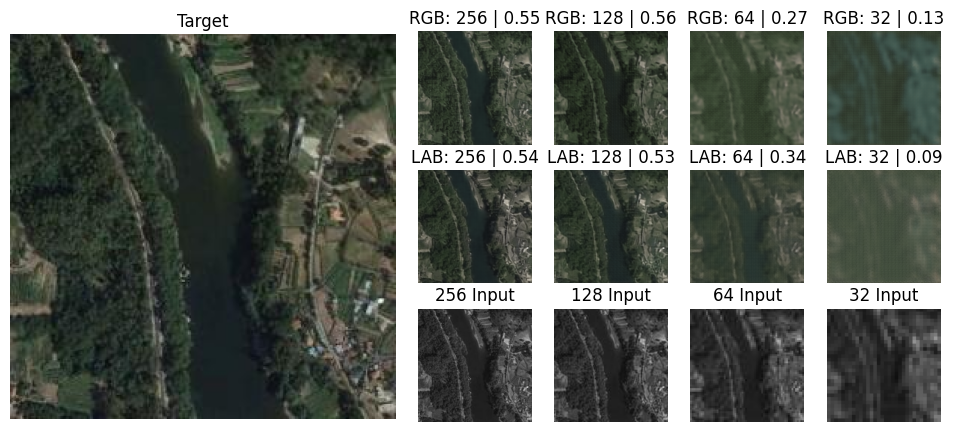

i: 699


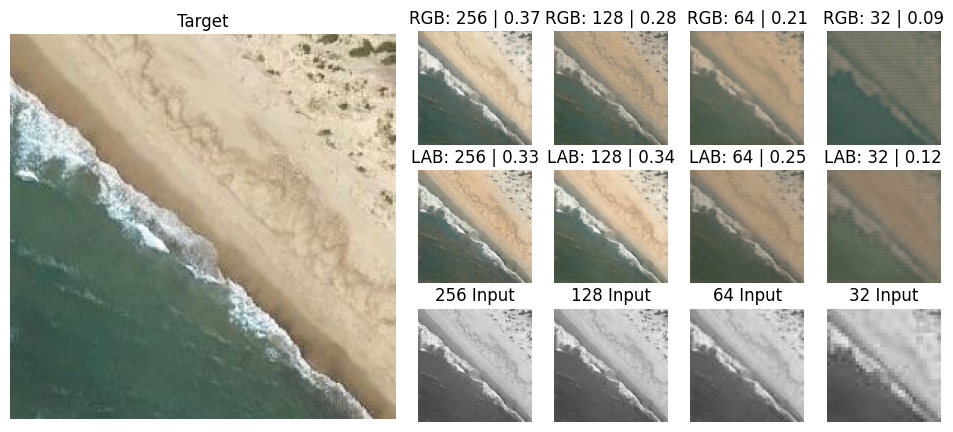

In [26]:
for esure in rgbesures:
  esure.eval()
  esure.to(device)

for esure in labesures:
  esure.eval()
  esure.to(device)

with torch.no_grad():
  for i in np.random.randint(len(color),size=2):
    plt.figure(figsize=(12,5.1))
    print("i:", i)
    large = plt.subplot2grid((3,7), (0,0), 3, 3)
    target = color[i]
    im = np.moveaxis(target.numpy(), [0, 1, 2], [2, 0, 1])
    large.imshow(im)
    large.axis('off')
    large.set_title('Target')

    inputs = [gray032[i], gray064[i], gray128[i], gray256[i]]
    dimlabels = [32,64,128,256]

    assert len(rgbesures) == len(inputs) == len(dimlabels)

    for j in range(4):
      plt.subplot(3,7,7-j)

      # Colorize the image
      t = inputs[j].unsqueeze(0).to(device)
      output = rgbesures[j](t)
      colorized_image_format = np.moveaxis(output.squeeze().cpu().detach().numpy(), [1,2], [0,1])

      # Show and compute MSSIM for outputs
      output_mssim = ms_ssim(to_lab_tensor(color[i].unsqueeze(0)).to(device), to_lab_tensor(output), data_range=1, size_average=True) # return scalar

      plt.imshow(colorized_image_format)
      plt.axis('off')
      plt.title(f'RGB: {dimlabels[j]} | {output_mssim:.2f}')

      plt.subplot(3,7,14-j)

      output = labesures[j](t*100)
      colorized_image_format = lab2rgb(np.moveaxis(output.squeeze().cpu().detach().numpy(), [1,2], [0,1]))

      # Show and compute MSSIM for outputs
      output_mssim = ms_ssim(to_lab_tensor(color[i].unsqueeze(0)).to(device), output, data_range=1, size_average=True) # return scalar

      plt.imshow(colorized_image_format)
      plt.axis('off')
      plt.title(f'LAB: {dimlabels[j]} | {output_mssim:.2f}')

      plt.subplot(3,7, 21-j)
      # Show and compute MSSIM for grey input
      upscaled = f.interpolate(inputs[j].reshape(1,1,dimlabels[j],dimlabels[j]),size=[256,256]) # upscale spatial dims to 256
      upscaled = np.moveaxis(upscaled.repeat(1,3,1,1).squeeze().numpy(), [1,2], [0,1]) # duplicate color channels to 3

      plt.imshow(upscaled)
      plt.axis('off')
      plt.title(f'{dimlabels[j]} Input')


    plt.show()



# Non Transfer Comparison

In [30]:
rgbntl032 = RGBAutoencoder('gray032')
rgbntl064 = RGBAutoencoder('gray064')
rgbntl128 = RGBAutoencoder('gray128')

#Paths to change
rgbntl032.encoder = torch.load('/content/CPSC-440-Project/models/RGB/no_transfer_32_dim_encoder_weights',map_location=device)
rgbntl032.decoder = torch.load('/content/CPSC-440-Project/models/RGB/no_transfer_32_dim_decoder_weights',map_location=device)

rgbntl064.encoder = torch.load('/content/CPSC-440-Project/models/RGB/no_transfer_64_dim_encoder_weights',map_location=device)
rgbntl064.decoder = torch.load('/content/CPSC-440-Project/models/RGB/no_transfer_64_dim_decoder_weights',map_location=device)

rgbntl128.encoder = torch.load('/content/CPSC-440-Project/models/RGB/no_transfer_128_dim_encoder_weights',map_location=device)
rgbntl128.decoder = torch.load('/content/CPSC-440-Project/models/RGB/no_transfer_128_dim_decoder_weights',map_location=device)

rgbntls = [rgbntl032, rgbntl064, rgbntl128]


labntl032 = LABAutoencoder('gray032')
labntl064 = LABAutoencoder('gray064')
labntl128 = LABAutoencoder('gray128')

#Paths to change
labntl032.encoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_encoder_32',map_location=device)
labntl032.decoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_decoder_32',map_location=device)

labntl064.encoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_encoder_64',map_location=device)
labntl064.decoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_decoder_64',map_location=device)

labntl128.encoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_encoder_128',map_location=device)
labntl128.decoder = torch.load('/content/CPSC-440-Project/models/LAB/notransfer_decoder_128',map_location=device)

labntls = [labntl032, labntl064, labntl128]

i: 789


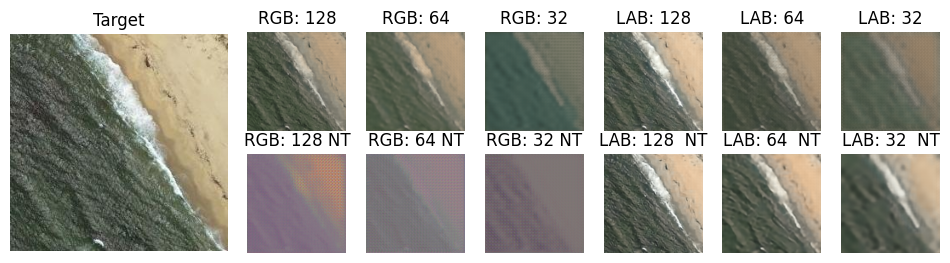

i: 1956


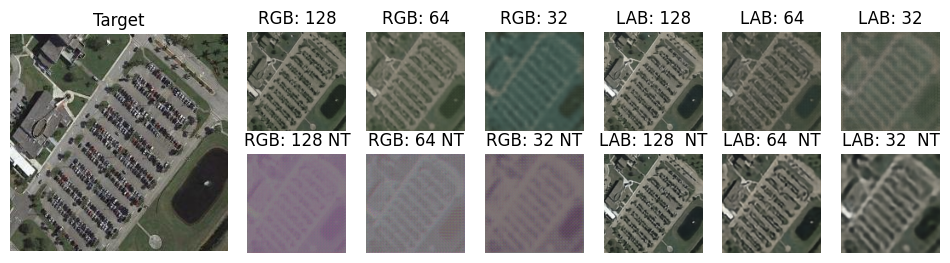

In [46]:
for esure in rgbesures:
  esure.eval()
  esure.to(device)

for esure in labesures:
  esure.eval()
  esure.to(device)

with torch.no_grad():
  for i in np.random.randint(len(color),size=2):
    plt.figure(figsize=(12,2.9))
    print("i:", i)
    large = plt.subplot2grid((2,8), (0,0), 2, 2)
    target = color[i]
    im = np.moveaxis(target.numpy(), [0, 1, 2], [2, 0, 1])
    large.imshow(im)
    large.axis('off')
    large.set_title('Target')

    inputs = [gray032[i], gray064[i], gray128[i], gray256[i]]
    dimlabels = [32,64,128,256]

    assert len(rgbesures) == len(inputs) == len(dimlabels)

    for j in range(3):
      plt.subplot(2,8,5-j)

      # Colorize the image
      t = inputs[j].unsqueeze(0).to(device)
      output = rgbesures[j](t)
      colorized_image_format = np.moveaxis(output.squeeze().cpu().detach().numpy(), [1,2], [0,1])

      # Show and compute MSSIM for outputs
      output_mssim = ms_ssim(to_lab_tensor(color[i].unsqueeze(0)).to(device), to_lab_tensor(output), data_range=1, size_average=True) # return scalar

      plt.imshow(colorized_image_format)
      plt.axis('off')
      plt.title(f'RGB: {dimlabels[j]}')

      plt.subplot(2,8,13-j)
      output = rgbntls[j](t)
      colorized_image_format = np.moveaxis(output.squeeze().cpu().detach().numpy(), [1,2], [0,1])

      # Show and compute MSSIM for outputs
      output_mssim = ms_ssim(to_lab_tensor(color[i].unsqueeze(0)).to(device), to_lab_tensor(output), data_range=1, size_average=True) # return scalar

      plt.imshow(colorized_image_format)
      plt.axis('off')
      plt.title(f'RGB: {dimlabels[j]} NT')


      plt.subplot(2,8,8-j)

      output = labesures[j](t*100)
      colorized_image_format = lab2rgb(np.moveaxis(output.squeeze().cpu().detach().numpy(), [1,2], [0,1]))

      # Show and compute MSSIM for outputs
      output_mssim = ms_ssim(to_lab_tensor(color[i].unsqueeze(0)).to(device), output, data_range=1, size_average=True) # return scalar

      plt.imshow(colorized_image_format)
      plt.axis('off')
      plt.title(f'LAB: {dimlabels[j]}')

      plt.subplot(2,8,16-j)
      output = labntls[j](t*100)
      colorized_image_format = lab2rgb(np.moveaxis(output.squeeze().cpu().detach().numpy(), [1,2], [0,1]))

      # Show and compute MSSIM for outputs
      output_mssim = ms_ssim(to_lab_tensor(color[i].unsqueeze(0)).to(device), output, data_range=1, size_average=True) # return scalar

      plt.imshow(colorized_image_format)
      plt.axis('off')
      plt.title(f'LAB: {dimlabels[j]}  NT')

    plt.show()

